# Final Project: Sentiment Analysis - Twitter Tweets
# By: Kafele Wimbley

In [97]:
from tensorflow.keras import Input
from tensorflow.keras.layers import Activation, Bidirectional, Conv1D, Dense, Dropout, Embedding, InputLayer, LSTM, MaxPooling1D, SimpleRNN
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.strings import regex_replace
from tensorflow.keras.utils import to_categorical
import tensorflow.keras as tf
import os
import shutil
import random
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import string
import collections
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from sklearn.utils import shuffle
nltk.download('stopwords')
stop_words = stopwords.words("english")

[nltk_data] Downloading package stopwords to C:\Users\Kafele-
[nltk_data]     Wimbley\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Reading in training data and shuffling 

In [100]:
# Ths cell reads in data, split data, and shuffle data 
dataTrain = pd.read_csv('twitter_training.csv')

# CSV File did not have a header so I created a new CSV file with header for each column 
headerList = ['id', 'name', 'sentiment', 'tweet']
dataTrain.to_csv("train.csv", header=headerList, index=False)

# Read in data and pop unnecessary attributes 
trainSample = pd.read_csv("train.csv")
trainSample.pop("id")
trainSample.pop("name")

# Using varuable to split data
numRowsTrain = len(trainSample) 

# Grabs all elements after border
trainX = (trainSample['tweet'])[:numRowsTrain]
trainY = (trainSample['sentiment'])[:numRowsTrain]

# Shuffle training data
combined = list(zip(trainX, trainY))
random.shuffle(combined)
trainX[:], trainY[:] = zip(*combined)

trainSample.head()

,sentiment,tweet
0,Irrelevant,ago experienced a game where a player had it g...
1,Positive,"Am I the only one who likes FIFA 21, is gonna ..."
2,Irrelevant,everybody so sweaty on @PlayApex today.. fucki...
3,Positive,I can ’ ′ t wait up to play My Mercy Moira Jun...
4,Positive,Tried GTA V... It's bloody expansive. Nice ro...


In [101]:
for i in range(0, 10):
    print("Sentiment: " + trainY[i])
    print("Tweet: " + trainX[i])

Sentiment: Irrelevant
Tweet: ago experienced a game where a player had it go afk for the whole game because they said a fat shit bit the load off and the screen started flooding and didn't notice until 15 mins into the game but their ground under their feet started to get wet... LoL players aren't even allowed.
Sentiment: Positive
Tweet: Am I the only one who likes FIFA 21, is gonna take some getting used to but I like it
Sentiment: Irrelevant
Tweet: everybody so sweaty on @PlayApex today.. fucking relax a new season isnt the end of the shitty world..
Sentiment: Positive
Tweet: I can ’ ′ t wait up to play My Mercy Moira Junk and Mei in Overwatch this next week!
Sentiment: Positive
Tweet: Tried GTA V... It's bloody expansive.  Nice road map; incl. camber and bumps and dips... BUT..... Things couldn't last more than 30 min & so in flat mode... I'll go for that VR patch (on the Epic Games store version). .. That huge world is just demanding it.
Sentiment: Irrelevant
Tweet: I love seeing N

### Reading in testing data and shuffling 

In [102]:
dataTest = pd.read_csv('twitter_test.csv')

# CSV File did not have a header so I created a new CSV file with header for each column 
headerList = ['id', 'name', 'sentiment', 'tweet']
dataTest.to_csv("test.csv", header=headerList, index=False)

# Read in data and pop unnecessary attributes 
testSample = pd.read_csv("test.csv")
testSample.pop("id")
testSample.pop("name")

# numbers of rows to read in from test dataset 
numRowsTest = len(testSample)

# reading in data from test dataset 
testX = (testSample['tweet'])[:numRowsTest]
testY = (testSample['sentiment'])[:numRowsTest]

# shuffle training dataset 
combined = list(zip(testX, testY))
random.shuffle(combined)
testX[:], testY[:] = zip(*combined)

testSample.head()

,sentiment,tweet
0,Negative,I've never been this tierd in my entire life #...
1,Neutral,Microsoft’s Xbox boss just gave an update on o...
2,Positive,this game looks insane wtf
3,Neutral,@PlayApex you got a bug when a game ranked is ...
4,Negative,More FIFA? Leslie Steiger must be joking! See ...


In [103]:
for i in range(0, 10):
    print("Sentiment: " + testY[i])
    print("Tweet: " + testX[i])

Sentiment: Negative
Tweet: I've never been this tierd in my entire life #LeagueOfLegends #struggle pic.twitter.com/PvI9sX4c7W
Sentiment: Neutral
Tweet: Microsoft’s Xbox boss just gave an update on one of the Xbox Series X’s most exciting features
#GamerNation #Gaming #VideoGames #XboxOne #XboxOneX #XCloud #XboxSeriesX  #RETROGAMINGhttps://bgr.com/2020/02/10/xbox-series-x-specs-vs-xbox-one-backward-compatibility-working-spencer/
Sentiment: Positive
Tweet: this game looks insane wtf
Sentiment: Neutral
Tweet: @PlayApex you got a bug when a game ranked is ended, my friend get 10 min penality and he dont leave the game .
Sentiment: Negative
Tweet: More FIFA? Leslie Steiger must be joking! See the horrible thing here ift.tt/2Y1TBtO :///
Sentiment: Negative
Tweet: Why does nobody want to sign for my @FGRFC_Official fifa 20 side I’m livid Messi being a pure uppity cunt
Sentiment: Positive
Tweet: Thanks @RockstarGames , you're rock stars!  #RedDeadRedemption pic.twitter.com/ztc25UcGRl
Sentiment

### Converting sentiment string labels to integer labels

In [104]:
# Function converts sentiment string labels into integers 
def labelInt(labels):
    numLabels = len(labels)
    for i in range(0, numLabels):
        if labels[i] == 'Negative':
            labels[i] = 0
        elif labels[i] == 'Neutral':
            labels[i] = 1 
        elif labels[i] == 'Positive':
            labels[i] = 2
        elif labels[i] == 'Irrelevant':
            labels[i] = 3
    return labels

trainY = labelInt(trainY)
testY = labelInt(testY)

### Text preprocessing 

In [105]:
def textPreproc(textX):
    numText = len(textX)
    for i in range(0, numText):
        
        # replace text with emply string if text value is NaN
        if pd.isna(textX[i]):
            textX[i] = ''
        # Remove numbers 
        textX[i] = re.sub('\w*\d+\w*', '', textX[i])
        # lower case all letters
        textX[i] = textX[i].lower()
        # removing all outside of ascii
        textX[i] = textX[i].encode('ascii', 'ignore').decode()
        # removing '\'
        textX[i] = re.sub("\'\w+", '',textX[i])
        # removing all stop words
        textX[i] = ' '.join([word for word in textX[i].split(' ') if word not in stop_words])
        # remove all punctuations
        textX[i] = re.sub('[%s]' % re.escape(string.punctuation), ' ', textX[i])
        # remove extra spaces
        textX[i] = re.sub('\s{2,}', ' ', textX[i])

    return textX

trainX = textPreproc(trainX)
testX = textPreproc(testX)

In [106]:
for i in range(0, 10):
    print("Sentiment: " + str(trainY[i]))
    print("Tweet: " + str(trainX[i]))

Sentiment: 3
Tweet: ago experienced game player go afk whole game said fat shit bit load screen started flooding notice mins game ground feet started get wet lol players even allowed 
Sentiment: 2
Tweet: one likes fifa gonna take getting used like
Sentiment: 3
Tweet: everybody sweaty playapex today fucking relax new season isnt end shitty world 
Sentiment: 2
Tweet:  wait play mercy moira junk mei overwatch next week 
Sentiment: 2
Tweet: tried gta v bloody expansive nice road map incl camber bumps dips but things last min flat mode go vr patch on epic games store version huge world demanding it 
Sentiment: 3
Tweet: love seeing naughty dog fanboys squirm every fifth cyberpunk gets locked up desperate fail pathetic x 
Sentiment: 2
Tweet: kind incredible games getting year xbox series x getting assassin creed valhalla watch dogs legion dirt fuser falconeer thanks gamepass gears tactics destiny beyond light before xmas cyberpunk medium 
Sentiment: 0
Tweet: mut pc servers down eahelp eamadde

In [107]:
for i in range(0, 10):
    print("Sentiment: " + str(testY[i]))
    print("Tweet: " + str(testX[i]))

Sentiment: 0
Tweet: never tierd entire life leagueoflegends struggle pic twitter com 
Sentiment: 1
Tweet: microsofts xbox boss gave update one xbox series xs exciting features gamernation gaming videogames xboxone xboxonex xcloud xboxseriesx retrogaminghttps bgr com xbox series x specs vs xbox one backward compatibility working spencer 
Sentiment: 2
Tweet: game looks insane wtf
Sentiment: 1
Tweet:  playapex got bug game ranked ended friend get min penality dont leave game 
Sentiment: 0
Tweet: fifa leslie steiger must joking see horrible thing ift tt 
Sentiment: 0
Tweet: nobody want sign fgrfc official fifa side im livid messi pure uppity cunt
Sentiment: 2
Tweet: thanks rockstargames rock stars reddeadredemption pic twitter com 
Sentiment: 3
Tweet: im gonna say imjustbait funniest meme page ever 
Sentiment: 3
Tweet: amazing mainstream media tries normalise muslim criminals terrorists bdutt painted burhan wani facebook star son schoolmaster washingtonpost made baghdadi austere scholar pr

### Numpy array conversion of training/ testing data

In [160]:
def prepare_data(text, label):
    textX = []
    labelsY = []

    for i in range(0, len(text)):
        textX.append(np.array(text[i]))
        labelsY.append(np.array(label[i]))
    
    return np.array(textX), np.array(labelsY)

trainXA, trainYA = prepare_data(trainX, trainY)
testXA, testYA = prepare_data(testX, testY)

# Print training dataset sentiment amount & shape of training features and labels
print(collections.Counter(trainYA))
print(trainXA.shape, trainYA.shape)

# Print testing dataset sentiment amoun & shape of testing features and labels
print(collections.Counter(testYA))
print(testXA.shape, testYA.shape)

Counter({0: 22542, 2: 20831, 1: 18318, 3: 12990})
(74681,) (74681,)
Counter({1: 285, 2: 277, 0: 266, 3: 171})
(999,) (999,)


### Oversampling of training/ testing data & converting labels to catergorical 

In [161]:
# reshaping training data inorder to oversample dataset 
feat = trainXA.reshape(-1,1)
label = trainYA.reshape(-1,1)

# oversampling training dataset which will result in equal amount of each type of sentiment and tweets 
oversample = RandomOverSampler(sampling_strategy='all')
xOver, yOver = oversample.fit_resample(feat, label)

# reshaping data again to correct format and converting training labels to categorical 
trainXA = xOver.reshape(-1)
trainYA = yOver.reshape(-1)
trainYA = to_categorical(yOver, 4)

# reshaping testing data inorder to oversample dataset 
testFeat = testXA.reshape(-1, 1)
testLabel = testYA.reshape(-1, 1)

# oversampling testing dataset which will result in equal amount of each type of sentiment and tweets 
testXOver, testYOver = oversample.fit_resample(testFeat, testLabel)

# reshaping data again to correct format and converting training labels to categorical 
testXA = testXOver.reshape(-1)
testYA = testYOver.reshape(-1)
testYA = to_categorical(testYOver, 4)

# Print training dataset sentiment amount & shape of training features and labels
print(collections.Counter(yOver))
print(trainXA.shape, trainYA.shape)

# Print testing dataset sentiment amoun & shape of testing features and labels
print(collections.Counter(testYOver))
print(testXA.shape, testYA.shape)

Counter({3: 22542, 2: 22542, 0: 22542, 1: 22542})
(90168,) (90168, 4)
Counter({0: 285, 1: 285, 2: 285, 3: 285})
(1140,) (1140, 4)


### Benchmark Simple RNN Model

In [163]:
tf.backend.clear_session()

vectorizeLayer = TextVectorization(output_mode = 'int')

# adapt() fits the TextVectorization layer to our text dataset. This is when the
vectorizeLayer.adapt(trainXA)

modelB = Sequential()

modelB.add(Input(shape=(1,), dtype = 'string'))

# text vectorization layer
modelB.add(vectorizeLayer)

# add an embedding layer to turn integers into fixed-length vectors
modelB.add(Embedding(vectorizeLayer.vocabulary_size(), 128))

# add a fully-connected recurrent layer
modelB.add(SimpleRNN(64))

# add a dense layer
modelB.add(Dense(64, activation = 'relu'))

# add softmax classifier
modelB.add(Dense(4, activation = 'softmax'))

# compiling the model
modelB.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
# getting the summary of the model
modelB.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         3395200   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                12352     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 3,411,972
Trainable params: 3,411,972
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
2255/2255 [==============================] - 69s 30ms/step - loss: 1.3625 - acc: 0.3108 - val_loss: 1.4348 - val_acc: 0.2802
Epoch 2/10
2255/2255 [==============================] - 75s 33ms/step - loss: 1.2488 - acc: 0.4047 - val_loss: 1.2350 - val_acc: 0.3542
Epoch 3/10
2255/2255 [==============================] - 77s 34ms/step - loss: 1.0160 - acc: 0.5633 - val_loss: 0.9246 - val_acc: 0.6598
Epoch 4/10
2255/2255 [==============================] - 76s 33ms/step - loss: 0.7403 - acc: 0.7378 - val_loss: 0.7313 - val_acc: 0.7592
Epoch 5/10
2255/2255 [==============================] - 80s 35ms/step - loss: 0.5693 - acc: 0.8075 - val_loss: 0.5222 - val_acc: 0.8400
Epoch 6/10
2255/2255 [==============================] - 77s 34ms/step - loss: 0.5475 - acc: 0.8218 - val_loss: 0.5246 - val_acc: 0.8283
Epoch 7/10
2255/2255 [==============================] - 78s 34ms/step - loss: 0.4486 - acc: 0.8524 - val_loss: 0.6256 - val_acc: 0.8268
Epoch 8/10
2255/2255 [==========================

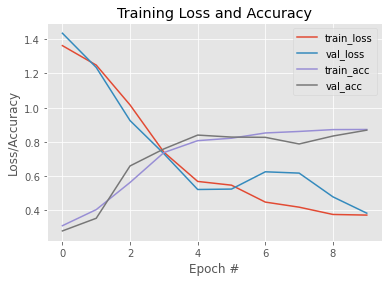

In [164]:
# epochs used for training
epochs = 10

# training the model
H = modelB.fit(trainXA, trainYA, validation_split = 0.2, epochs = epochs)

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['acc'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_acc'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

In [184]:
print('Test Accuracy')
predictedTestY = modelB.predict(testXA)
predictedTestY = predictedTestY.argmax(axis=1)
testY_class = testYA.argmax(axis=1)
print(classification_report(testY_class, predictedTestY))

Test Accuracy
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       285
           1       0.90      0.85      0.87       285
           2       0.93      0.90      0.91       285
           3       0.86      0.94      0.89       285

    accuracy                           0.90      1140
   macro avg       0.90      0.90      0.90      1140
weighted avg       0.90      0.90      0.90      1140



### Trial 1 Bidirectional Simple RNN

In [173]:
tf.backend.clear_session()

modelT1 = Sequential()

modelT1.add(Input(shape=(1,), dtype = 'string'))

# text vectorization layer
modelT1.add(vectorizeLayer)

# add an embedding layer to turn integers into fixed-length vectors
modelT1.add(Embedding(vectorizeLayer.vocabulary_size(), 128))

# add a fully-connected recurrent layer
modelT1.add(Bidirectional(SimpleRNN(64)))

# add a dense layer
modelT1.add(Dense(64, activation = 'relu'))

# add softmax classifier
modelT1.add(Dense(4, activation = 'softmax'))

# compiling the model
modelT1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
# getting the summary of the model
modelT1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         3395200   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               24704     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 3,428,420
Trainable params: 3,428,420
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
2255/2255 [==============================] - 89s 39ms/step - loss: 0.7499 - acc: 0.6962 - val_loss: 0.3271 - val_acc: 0.8775
Epoch 2/10
2255/2255 [==============================] - 89s 40ms/step - loss: 0.2684 - acc: 0.8992 - val_loss: 0.2003 - val_acc: 0.9279
Epoch 3/10
2255/2255 [==============================] - 86s 38ms/step - loss: 0.1815 - acc: 0.9301 - val_loss: 0.1930 - val_acc: 0.9244
Epoch 4/10
2255/2255 [==============================] - 86s 38ms/step - loss: 0.1531 - acc: 0.9390 - val_loss: 0.1827 - val_acc: 0.9333
Epoch 5/10
2255/2255 [==============================] - 90s 40ms/step - loss: 0.1386 - acc: 0.9444 - val_loss: 0.1783 - val_acc: 0.9373
Epoch 6/10
2255/2255 [==============================] - 86s 38ms/step - loss: 0.1255 - acc: 0.9474 - val_loss: 0.1796 - val_acc: 0.9362
Epoch 7/10
2255/2255 [==============================] - 88s 39ms/step - loss: 0.1205 - acc: 0.9496 - val_loss: 0.1788 - val_acc: 0.9325
Epoch 8/10
2255/2255 [==========================

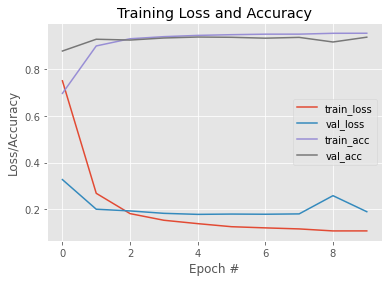

In [174]:
# epochs used for training
epochs = 10

# training the model
H = modelT1.fit(trainXA, trainYA, validation_split = 0.2, epochs = epochs)

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['acc'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_acc'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

In [185]:
print('Test Accuracy')
predictedTestY = modelT1.predict(testXA)
predictedTestY = predictedTestY.argmax(axis=1)
testY_class = testYA.argmax(axis=1)
print(classification_report(testY_class, predictedTestY))

Test Accuracy
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       285
           1       0.97      0.94      0.95       285
           2       0.95      0.98      0.96       285
           3       0.98      0.99      0.98       285

    accuracy                           0.97      1140
   macro avg       0.97      0.97      0.97      1140
weighted avg       0.97      0.97      0.97      1140



### Trial 2 Bidirectional Simple RNN with Dropout 

In [178]:
tf.backend.clear_session()

modelT2 = Sequential()

modelT2.add(Input(shape=(1,), dtype = 'string'))

# text vectorization layer
modelT2.add(vectorizeLayer)

# add an embedding layer to turn integers into fixed-length vectors
modelT2.add(Embedding(vectorizeLayer.vocabulary_size(), 128))

# add a fully-connected recurrent layer
modelT2.add(Bidirectional(SimpleRNN(64)))
modelT2.add(Dropout(0.5))

# add a dense layer
modelT2.add(Dense(64, activation = 'relu'))
modelT2.add(Dropout(0.5))

# add softmax classifier
modelT2.add(Dense(4, activation = 'softmax'))

# compiling the model
modelT2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
# getting the summary of the model
modelT2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         3395200   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               24704     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2

Epoch 1/10
2255/2255 [==============================] - 90s 39ms/step - loss: 0.9232 - acc: 0.6192 - val_loss: 0.4794 - val_acc: 0.8202
Epoch 2/10
2255/2255 [==============================] - 85s 38ms/step - loss: 0.4091 - acc: 0.8551 - val_loss: 0.2550 - val_acc: 0.8943
Epoch 3/10
2255/2255 [==============================] - 80s 36ms/step - loss: 0.2815 - acc: 0.8983 - val_loss: 0.2303 - val_acc: 0.9114
Epoch 4/10
2255/2255 [==============================] - 82s 36ms/step - loss: 0.2317 - acc: 0.9150 - val_loss: 0.2019 - val_acc: 0.9197
Epoch 5/10
2255/2255 [==============================] - 84s 37ms/step - loss: 0.2145 - acc: 0.9215 - val_loss: 0.2127 - val_acc: 0.9147
Epoch 6/10
2255/2255 [==============================] - 83s 37ms/step - loss: 0.1869 - acc: 0.9301 - val_loss: 0.2064 - val_acc: 0.9180
Epoch 7/10
2255/2255 [==============================] - 92s 41ms/step - loss: 0.1834 - acc: 0.9311 - val_loss: 0.2004 - val_acc: 0.9188
Epoch 8/10
2255/2255 [==========================

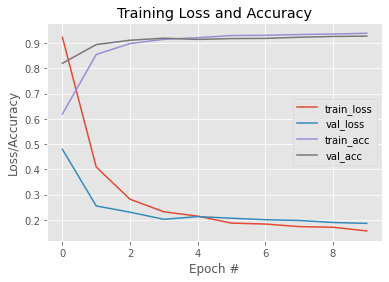

In [179]:
# epochs used for training
epochs = 10

# training the model
H = modelT2.fit(trainXA, trainYA, validation_split = 0.2, epochs = epochs)

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['acc'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_acc'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

In [186]:
print('Test Accuracy')
predictedTestY = modelT2.predict(testXA)
predictedTestY = predictedTestY.argmax(axis=1)
testY_class = testYA.argmax(axis=1)
print(classification_report(testY_class, predictedTestY))

Test Accuracy
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       285
           1       0.99      0.95      0.97       285
           2       0.96      0.98      0.97       285
           3       0.98      0.98      0.98       285

    accuracy                           0.97      1140
   macro avg       0.97      0.97      0.97      1140
weighted avg       0.97      0.97      0.97      1140



### Trial 3 LSTM

In [181]:
tf.backend.clear_session()

vectorizeLayer = TextVectorization(output_mode = 'int')

vectorizeLayer.adapt(trainXA)

modelT3 = Sequential()

modelT3.add(Input(shape=(1,), dtype = 'string'))

# add layer to the model
modelT3.add(vectorizeLayer)

# add an embedding layer to turn integers into fixed-length vectors
modelT3.add(Embedding(vectorizeLayer.vocabulary_size(), 128))

# add a fully-connected recurrent layer
modelT3.add(LSTM(64))

# add a dense layer
modelT3.add(Dense(64, activation = 'relu'))
modelT3.add(Dropout(0.5))

# add softmax classifier
modelT3.add(Dense(4, activation = 'sigmoid'))

# compiling the model
modelT3.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
# getting the summary of the model
modelT3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         3395200   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 3,449,028
Trainable params: 3,449,028
Non-trainable params: 0
______________________________________________

Epoch 1/10
2255/2255 [==============================] - 103s 45ms/step - loss: 1.0039 - acc: 0.5798 - val_loss: 0.6889 - val_acc: 0.7353
Epoch 2/10
2255/2255 [==============================] - 102s 45ms/step - loss: 0.5305 - acc: 0.8141 - val_loss: 0.4916 - val_acc: 0.7974
Epoch 3/10
2255/2255 [==============================] - 101s 45ms/step - loss: 0.3655 - acc: 0.8674 - val_loss: 0.3629 - val_acc: 0.8570
Epoch 4/10
2255/2255 [==============================] - 99s 44ms/step - loss: 0.2884 - acc: 0.8925 - val_loss: 0.3206 - val_acc: 0.8648
Epoch 5/10
2255/2255 [==============================] - 101s 45ms/step - loss: 0.2413 - acc: 0.9096 - val_loss: 0.2554 - val_acc: 0.8867
Epoch 6/10
2255/2255 [==============================] - 103s 46ms/step - loss: 0.2061 - acc: 0.9215 - val_loss: 0.2163 - val_acc: 0.9168
Epoch 7/10
2255/2255 [==============================] - 106s 47ms/step - loss: 0.1816 - acc: 0.9282 - val_loss: 0.2537 - val_acc: 0.9055
Epoch 8/10
2255/2255 [====================

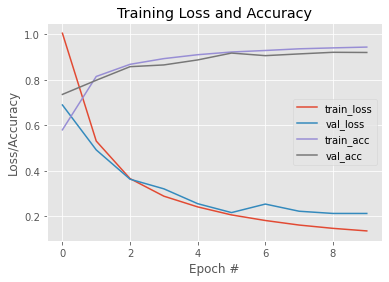

In [182]:
# epochs used for training
epochs = 10

# training the model
H = modelT3.fit(trainXA, trainYA, validation_split = 0.2, epochs = epochs)

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['acc'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_acc'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

In [187]:
print('Test Accuracy')
predictedTestY = modelT3.predict(testXA)
predictedTestY = predictedTestY.argmax(axis=1)
testY_class = testYA.argmax(axis=1)
print(classification_report(testY_class, predictedTestY))

Test Accuracy
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       285
           1       0.99      0.93      0.96       285
           2       0.94      0.98      0.96       285
           3       0.97      0.97      0.97       285

    accuracy                           0.96      1140
   macro avg       0.96      0.96      0.96      1140
weighted avg       0.96      0.96      0.96      1140

